<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/experimental/Generate_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb -q
!pip install pathy -q
!pip install comet_ml -q

     |████████████████████████████████| 2.0MB 12.3MB/s 
     |████████████████████████████████| 163kB 64.7MB/s 
     |████████████████████████████████| 133kB 25.2MB/s 
     |████████████████████████████████| 102kB 7.4MB/s 
     |████████████████████████████████| 71kB 5.2MB/s 
     |████████████████████████████████| 122kB 16.0MB/s 
     |████████████████████████████████| 256kB 14.1MB/s 
     |████████████████████████████████| 522kB 31.1MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 


In [7]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-wmax', '--window_size_max', default=40, type=int)
parser.add_argument('-wmin', '--window_size_min', default=20, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=512, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-embd', '--img_embedding_size', default=64, type=int, help='Embedding size of features,goal space')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=200000)
parser.add_argument('-r', '--resume', default=False, action='store_true')
parser.add_argument('-B', '--beta', type=float, default=0.00003)
parser.add_argument('-i', '--images', default=False, action='store_true')
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP

### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset UR5
--test_dataset UR5
-tfr
'''.split())

## Sample colab config
args = parser.parse_args('''
refactor_test
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-tfr
-s GCS
-d TPU
-b 512
-la 2048
-le 512
-lp 512
-z 256
-lr 3e-4
-wmin 10
-wmax 40
-i
--bucket_name lfp_europe_west4_a
'''.split())

# ## Sample colab config
# args = parser.parse_args('''
# QuantB0_01
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -s DRIVE
# -d TPU
# -b 512
# -la 2048
# -le 512
# -lp 512
# -z 256
# -lr 3e-4
# -B 0.01
# -n 5
# -q 8
# '''.split())

print(args)

Namespace(actor_layer_size=2048, batch_size=512, beta=3e-05, bucket_name='lfp_europe_west4_a', colab=True, data_source='GCS', device='TPU', encoder_layer_size=512, from_tfrecords=True, gcbc=False, images=True, img_embedding_size=64, latent_dim=256, learning_rate=0.0003, num_distribs=None, planner_layer_size=512, qbits=None, resume=False, run_name='refactor_test', test_datasets=['UR5_slow_gripper_test'], tpu_name=None, train_datasets=['UR5', 'UR5_slow_gripper', 'UR5_high_transition'], train_steps=200000, window_size_max=40, window_size_min=10)


In [8]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import numpy as np
import tensorflow as tf
import time



pp = pprint.PrettyPrinter(indent=4)
# In[4]:


#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/learning_from_play')
    # Clone repo
    try:
        get_ipython().system("git clone 'https://github.com/sholtodouglas/learning_from_play' {WORKING_PATH}")
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path.cwd()
    print(f'Working path: {WORKING_PATH}')

# Change working directory to learning_from_play
os.chdir(WORKING_PATH)
import lfp

# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
elif args.data_source == 'GCS':
    if args.colab:
      auth.authenticate_user()
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    project_id = 'learning-from-play-303306'
    logging.warning(f'You are accessing GCS data from {region}, make sure this is the same as your bucket {args.bucket_name}')
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
fatal: destination path '/content/learning_from_play' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading data from Google Cloud Storage


Storage path: gs://lfp_europe_west4_a/


In [9]:

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [30]:
dl = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=1,  window_size=args.window_size_max, min_window_size=args.window_size_min)

In [31]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)

{   'acts': TensorSpec(shape=(1, 40, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(1, None), dtype=tf.int32, name=None),
    'goal_imgs': TensorSpec(shape=(1, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'goals': TensorSpec(shape=(1, 40, 11), dtype=tf.float32, name=None),
    'imgs': TensorSpec(shape=(1, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'masks': TensorSpec(shape=(1, 40), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(1, 40, 18), dtype=tf.float32, name=None),
    'proprioceptive_features': TensorSpec(shape=(1, 40, 7), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(1,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(1, None), dtype=tf.int32, name=None)}


In [32]:
t_it = iter(train_dataset)


In [33]:
import time

In [39]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

def serialise(data):
    
    obs, acts, goals, seq_lens, masks, dataset_path, tstep_idxs , imgs , goal_imgs, proprioceptive_features = data['obs'], \
    data['acts'], data['goals'], data['seq_lens'], data['masks'], data['dataset_path'], data['tstep_idxs'], data['imgs'], data['goal_imgs'], data['proprioceptive_features']
    
    # obs (1, 40, 18)
    # acts (1, 40, 7)
    # goals (1, 40, 11)
    # seq_lens (1,)
    # masks (1, 40)
    # dataset_path (1, 40)
    # tstep_idxs (1, 40)
    # imgs (1, 40, 200, 200, 3)
    # goal_imgs (1, 40, 200, 200, 3)
    # proprioceptive_features (1, 40, 7)

    goal_imgs = tf.expand_dims(goal_imgs[:,0,:,:,:],1) # crete a :, 1, :,:,: shaped goal images for less file IO

    
    obs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(obs).numpy(),]))
    acts = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(acts).numpy(),]))
    goals = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(goals).numpy(),])) 
    seq_lens = Feature(int64_list=Int64List(value=[seq_lens,]))
    masks = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(masks).numpy(),])) 

    imgs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(imgs).numpy(),]))
    goal_imgs = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(goal_imgs).numpy(),]))
    proprioceptive_features = Feature(bytes_list=BytesList(value=[tf.io.serialize_tensor(proprioceptive_features).numpy(),]))

    
    features = Features(feature={
              'obs':obs,
              'acts':acts,
              'goals':goals,
              'seq_lens':seq_lens,
              'masks':masks,
              'imgs':imgs,
              'goal_imgs':goal_imgs,
              'proprioceptive_features':proprioceptive_features})
    
    example = Example(features=features)
    
    return example.SerializeToString()


In [40]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    #image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [200,200, 3]) # explicit size needed for TPU
    return image

def read_tfrecord(example):
    LABELED_TFREC_FORMAT = {
            'obs':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'acts':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'goals':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'seq_lens':tf.io.FixedLenFeature([], tf.int64),
            'masks':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'imgs':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'goal_imgs':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
            'proprioceptive_features':tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring,
    }
    data = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    obs = tf.io.parse_tensor(data['obs'], tf.float32) 
    acts = tf.io.parse_tensor(data['acts'], tf.float32) 
    goals = tf.io.parse_tensor(data['goals'], tf.float32)  
    seq_lens = tf.cast(data['seq_lens'], tf.int32) # this is meant to be 32 even though you serialize as 64
    masks = tf.io.parse_tensor(data['masks'], tf.float32) 
    imgs = tf.io.parse_tensor(data['imgs'], tf.uint8)   
    goal_imgs = tf.io.parse_tensor(data['goal_imgs'], tf.uint8)   
    proprioceptive_features =tf.io.parse_tensor( data['proprioceptive_features'], tf.float32) 

    
    # img = decode_image(data['img'])

    return {  'obs':obs,
              'acts':acts,
              'goals':goals,
              'seq_lens':seq_lens,
              'masks':masks,
              'imgs':imgs,
              'goal_imgs':goal_imgs,
              'proprioceptive_features':proprioceptive_features}

In [41]:
data_paths = [str(STORAGE_PATH/'precompute')+f"/{x}.tfrecords" for x in range(0,23)]

In [43]:


for path in data_paths:
  with tf.io.TFRecordWriter(path) as file_writer:
    print(path)
    for i in range(0,10):
        byte_stream = serialise(t_it.next())
        file_writer.write(byte_stream)

gs://lfp_europe_west4_a/precompute/0.tfrecords
gs://lfp_europe_west4_a/precompute/1.tfrecords
gs://lfp_europe_west4_a/precompute/2.tfrecords
gs://lfp_europe_west4_a/precompute/3.tfrecords
gs://lfp_europe_west4_a/precompute/4.tfrecords
gs://lfp_europe_west4_a/precompute/5.tfrecords
gs://lfp_europe_west4_a/precompute/6.tfrecords
gs://lfp_europe_west4_a/precompute/7.tfrecords
gs://lfp_europe_west4_a/precompute/8.tfrecords
gs://lfp_europe_west4_a/precompute/9.tfrecords
gs://lfp_europe_west4_a/precompute/10.tfrecords
gs://lfp_europe_west4_a/precompute/11.tfrecords
gs://lfp_europe_west4_a/precompute/12.tfrecords
gs://lfp_europe_west4_a/precompute/13.tfrecords
gs://lfp_europe_west4_a/precompute/14.tfrecords


KeyboardInterrupt: ignored

In [48]:
batch_size = 16
def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=60) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=600)
    dataset =   dataset.repeat()\
                .batch(batch_size, drop_remainder=True)\
                # .prefetch(dl.prefetch_size)
    return dataset



In [50]:
data_paths = [str(STORAGE_PATH/'precompute')+f"/{x}.tfrecords" for x in range(0,13)]
d =load_tf_records(data_paths, ordered=False)#['/home/sholto/Desktop/AI/learning_from_play/data/UR5_high_transition/tf_records/21.tfrecords'], ordered=True) #record_paths
print(d)
d = iter(d)
x = d.next()

<BatchDataset shapes: {obs: <unknown>, acts: <unknown>, goals: <unknown>, seq_lens: (16,), masks: <unknown>, imgs: <unknown>, goal_imgs: <unknown>, proprioceptive_features: <unknown>}, types: {obs: tf.float32, acts: tf.float32, goals: tf.float32, seq_lens: tf.int32, masks: tf.float32, imgs: tf.uint8, goal_imgs: tf.uint8, proprioceptive_features: tf.float32}>


In [70]:
t = time.time()
for i in range(0,10):
  # print(i)
  x = d.next()
print(time.time()-t)

1.0041556358337402


In [53]:
dl = lfp.data.PlayDataloader(include_imgs = args.images, batch_size=batch_size,  window_size=args.window_size_max, min_window_size=args.window_size_min)
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)
test_it = iter(train_dataset)

{   'acts': TensorSpec(shape=(16, 40, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(16, None), dtype=tf.int32, name=None),
    'goal_imgs': TensorSpec(shape=(16, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'goals': TensorSpec(shape=(16, 40, 11), dtype=tf.float32, name=None),
    'imgs': TensorSpec(shape=(16, 40, 200, 200, 3), dtype=tf.uint8, name=None),
    'masks': TensorSpec(shape=(16, 40), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(16, 40, 18), dtype=tf.float32, name=None),
    'proprioceptive_features': TensorSpec(shape=(16, 40, 7), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(16,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(16, None), dtype=tf.int32, name=None)}
4.210890531539917


In [75]:
t = time.time()
for i in range(0,10):
  test_it.next()
print(time.time()-t)

0.0570371150970459


In [76]:
for i in range(0, 100):
  example = t_it.next()

In [ ]:
# np.frombuffer(example['goal_imgs'].numpy().tobytes(), np.uint8)

In [ ]:
bstr = serialise(example)

In [ ]:
d = read_tfrecord(bstr)

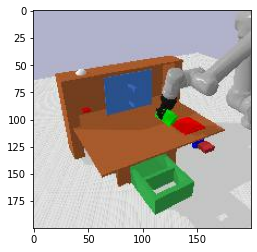

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(d['imgs'][0,15])

In [ ]:


def load_tf_records(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    # check, does this ignore intra order or just inter order? Both are an issue!
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) # automatically interleaves reads from multiple files - keep it at 1 we need the order
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

d =load_dataset([record_paths], ordered=True)#['/home/sholto/Desktop/AI/learning_from_play/data/UR5_high_transition/tf_records/21.tfrecords'], ordered=True) #record_paths
print(d)
d = iter(d)

In [ ]:
for k,v in example.items():
  print(k, v.shape)

In [ ]:
d





with tf.io.TFRecordWriter(str(path/'tf_records/')+f"/{demo}.tfrecords") as file_writer:
            for data in it:
                byte_stream = serialise(data)
                file_writer.write(byte_stream)